In [29]:
import os 
import pytorch_lightning as pl
import seml
import numpy as np
import torch

import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.base.vae import VAE
from scvi.distributions import NegativeBinomial

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

In [30]:
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('allepalma/scCFM_vae_sweep/model-mgg4sgtk:v0', type='model')
# artifact_dir = artifact.download()

In [31]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_key': 'experimental_time', 
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [0.8, 0.2],
            'batch_size': 256, 'num_workers': 2}

model_config = {'n_epochs': 200, 
          'kl_weight': None, 
          'likelihood': 'nb', 
          'dropout': False, 
          'dropout_p': False, 
          'hidden_dims': [256, 128, 64], 
          'batch_norm': True, 
          'kl_warmup_fraction': 1}

In [32]:
# Initialize datamodule
datamodule = scDataModule(**datamodule)



# Initialize the model 
model = VAE(in_dim = datamodule.in_dim,
            **model_config) 

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [33]:
model.load_state_dict(torch.load("/nfs/homedirs/pala/scCFM/notebooks/train_autoencoder/eb/model_high_kl.ckpt")["state_dict"])

<All keys matched successfully>

**Latent space structure**

In [34]:
cells = []
annot = []
with torch.no_grad():
    for batch in datamodule.train_dataloader():
        annot.append(batch["cond"])
        mu = model.encode(batch["X"])["mu"]
        cells.append(mu)

In [35]:
cells= torch.cat(cells, dim=0)
annot = pd.DataFrame(torch.cat(annot).numpy())
annot.columns = ["experimental_time"]

In [36]:
adata = sc.AnnData(X=cells.cpu().numpy(), 
                  obs=annot)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [37]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

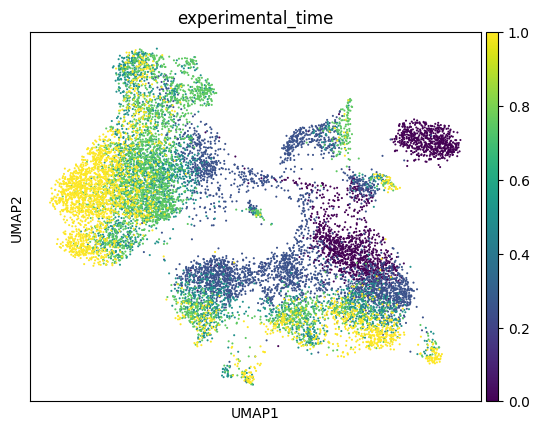

In [38]:
sc.pl.umap(adata, color="experimental_time")

**Generative model from amoritzed**

In [39]:
real_data = [] 
generated_amortized_data = []
generated_data = []
annot = []

with torch.no_grad():
    for batch in datamodule.train_dataloader():
        real_data.append(batch["X"].numpy())
        annot.append(batch["cond"])
        # Amortized
        decoder_output, _, _ = model(batch)
        nb = NegativeBinomial(mu=decoder_output["mu"], theta=torch.exp(model.theta))
        generated_amortized_data.append(nb.sample())
        # Non-amortized 
        z = torch.rand(batch["X"].shape[0], model.latent_dim).to(model.device)
        decoder_output = model.decode(z, library_size=batch["X"].sum(1))
        nb = NegativeBinomial(mu=decoder_output["mu"], theta=torch.exp(model.theta))
        generated_data.append(nb.sample())

In [40]:
real_data = np.concatenate(real_data)
generated_amortized_data = np.concatenate(generated_amortized_data)
generated_data = np.concatenate(generated_data)

Check all together

In [41]:
all_data = np.concatenate([real_data, generated_amortized_data, generated_data], axis=0)
dataset_type = ["real" for _ in range(len(real_data))] + ["generated_amortized" for _ in range(len(generated_amortized_data))] + ["generated" for _ in range(len(generated_data))]
dataset_type_df = pd.DataFrame(dataset_type)
dataset_type_df.columns = ["dataset_type"]
annot = pd.DataFrame(torch.cat(annot).numpy())
annot.columns = ["experimental_time"]

In [42]:
adata = sc.AnnData(X=all_data, 
                  obs=dataset_type_df)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [43]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


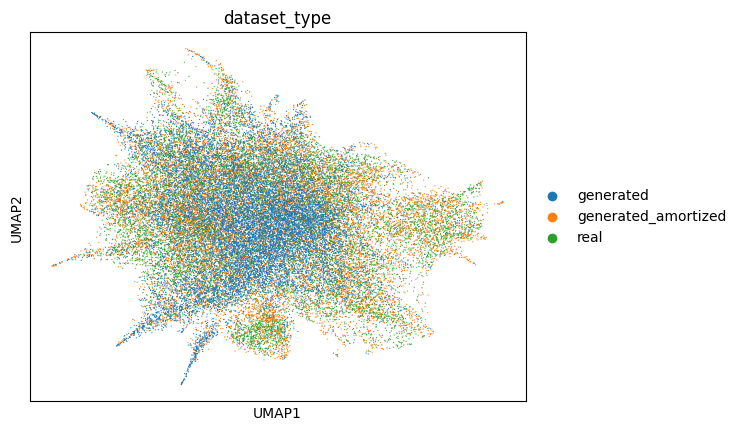

In [44]:
sc.pl.umap(adata, color="dataset_type")

Check alone

In [45]:
adata_amortized = sc.AnnData(X=generated_amortized_data, obs=annot)
adata_generated = sc.AnnData(X=generated_data)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


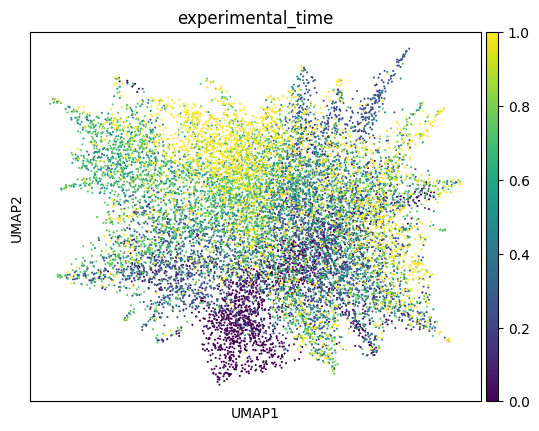

In [46]:
sc.tl.pca(adata_amortized)
sc.pp.neighbors(adata_amortized)
sc.tl.umap(adata_amortized)
sc.pl.umap(adata_amortized, color="experimental_time")

Real

In [48]:
adata_real = sc.AnnData(X=real_data, obs=annot)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


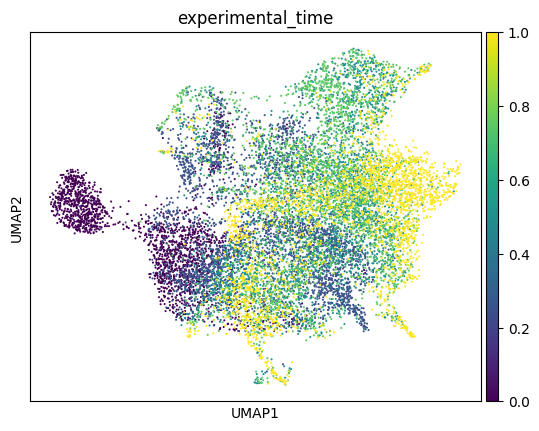

In [49]:
sc.tl.pca(adata_real)
sc.pp.neighbors(adata_real)
sc.tl.umap(adata_real)
sc.pl.umap(adata_real, color="experimental_time")

**Only amortized and real**

In [50]:
amortized_and_real = np.concatenate([real_data, generated_amortized_data], axis=0)
dataset_type = ["real" for _ in range(len(real_data))] + ["generated_amortized" for _ in range(len(generated_amortized_data))] 
dataset_type_df = pd.DataFrame(dataset_type)
dataset_type_df.columns = ["dataset_type"]
annot = pd.concat([annot, annot], axis=0).reset_index(drop=True)
annot.columns = ["experimental_time"]

In [51]:
pd.concat([dataset_type_df, annot], axis=1)

,dataset_type,experimental_time
0,real,0.50
1,real,0.25
2,real,1.00
3,real,0.50
4,real,0.25
...,...,...
26619,generated_amortized,1.00
26620,generated_amortized,0.00
26621,generated_amortized,0.75
26622,generated_amortized,0.50


In [52]:
adata_real_amortized = sc.AnnData(X=amortized_and_real, 
                                      obs=pd.concat([dataset_type_df, annot], axis=1))

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [53]:
sc.tl.pca(adata_real_amortized)
sc.pp.neighbors(adata_real_amortized)
sc.tl.umap(adata_real_amortized)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


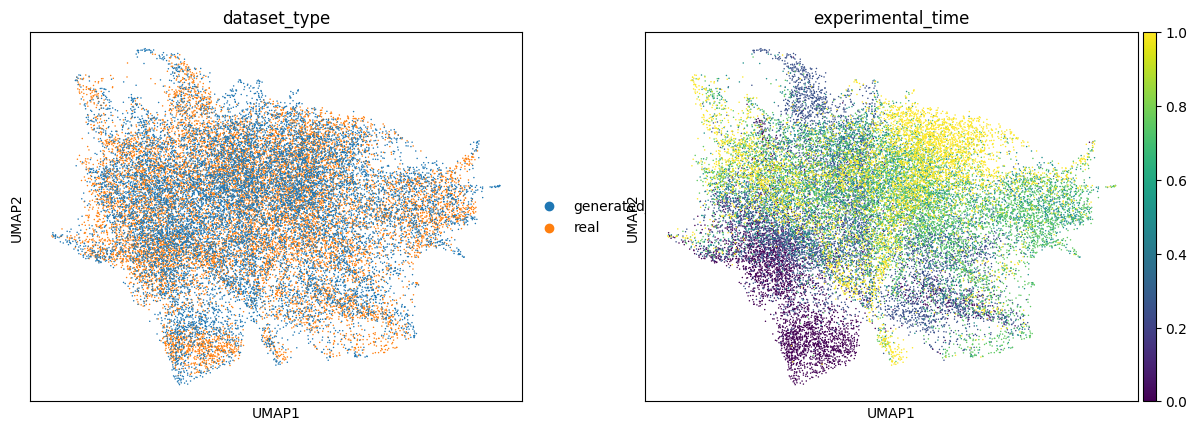

In [54]:
sc.pl.umap(adata_real_amortized, color=["dataset_type", "experimental_time"])

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


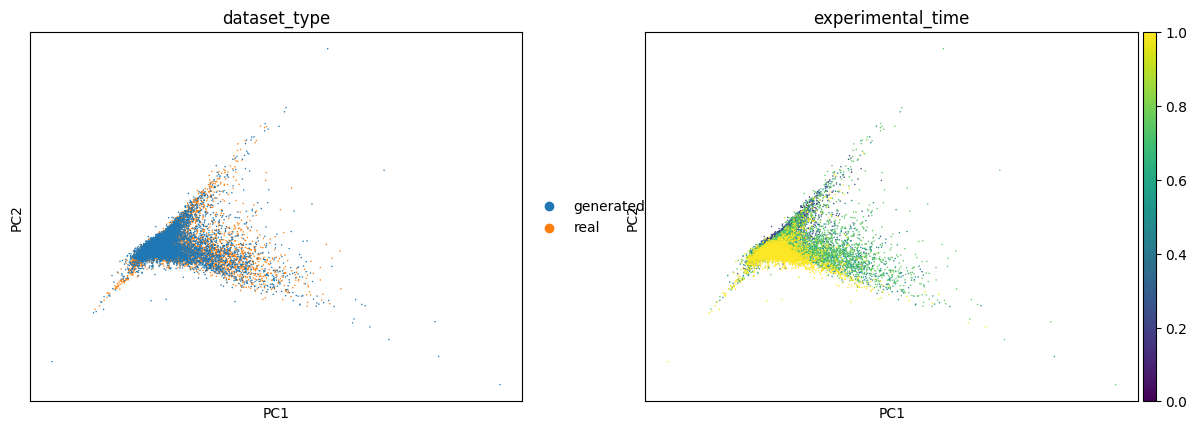

In [55]:
sc.pl.pca(adata_real_amortized, color=["dataset_type", "experimental_time"])

In [69]:
class MyManifold():
    def metric(self, c, return_deriv=False):
        N, D = c.shape  # N is number of points where we evaluate the metric; D is the manifold dimension
        sq_dist_to_origin = torch.sum(c**2, dim=1, keepdim=True)  # Nx1
        G = (1 + sq_dist_to_origin).unsqueeze(-1) * torch.eye(D).repeat(N, 1, 1)  # NxDxD
        return G

m = MyManifold()

In [71]:
a = torch.randint(0, 5, (4,5))

m.metric(a)

tensor([[[31.,  0.,  0.,  0.,  0.],
         [ 0., 31.,  0.,  0.,  0.],
         [ 0.,  0., 31.,  0.,  0.],
         [ 0.,  0.,  0., 31.,  0.],
         [ 0.,  0.,  0.,  0., 31.]],

        [[21.,  0.,  0.,  0.,  0.],
         [ 0., 21.,  0.,  0.,  0.],
         [ 0.,  0., 21.,  0.,  0.],
         [ 0.,  0.,  0., 21.,  0.],
         [ 0.,  0.,  0.,  0., 21.]],

        [[24.,  0.,  0.,  0.,  0.],
         [ 0., 24.,  0.,  0.,  0.],
         [ 0.,  0., 24.,  0.,  0.],
         [ 0.,  0.,  0., 24.,  0.],
         [ 0.,  0.,  0.,  0., 24.]],

        [[24.,  0.,  0.,  0.,  0.],
         [ 0., 24.,  0.,  0.,  0.],
         [ 0.,  0., 24.,  0.,  0.],
         [ 0.,  0.,  0., 24.,  0.],
         [ 0.,  0.,  0.,  0., 24.]]])

In [72]:
a

tensor([[3, 4, 0, 2, 1],
        [1, 3, 1, 3, 0],
        [1, 4, 1, 2, 1],
        [3, 1, 3, 0, 2]])